# Fun exercises on Spark using the Movielens Dataset

We are going to use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset for these exercises. This is non trivial and should expand to about 1GB on you hard-drive.

Download and unzip [MovieLens 25M Dataset](https://grouplens.org/datasets/movielens/25m/) for this analysis.

Either ensure the data is in ```"./data/ml-25m"``` folder or update the path to the data below.

**Citation**:  
*F. Maxwell Harper and Joseph A. Konstan.* 2015.  
The MovieLens Datasets: History and Context.  
ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>  

You got this.  


## Approach

The idea is to tackle simple Spark use-cases first and move on to more complex ones.  

The first exercise is just loading the data, then with each file we get into progressively more and more involved munging.  

We start by simple cleanup and counting related beats on the ```Tags``` data, and then get into more involved ideas on the ```movies``` data. The fun progressively increases.  

By the end you'd not only have an idea of PySpark, but also how we ask questions and analyze a chunk of data. You may also end up with a watch-list to binge on your next weekend. :) 


In [1]:
# Step 1: initialize findspark
import findspark
findspark.init()

In [2]:
# Step 2: import pyspark
import pyspark
from pyspark.sql import SparkSession
pyspark.__version__

'3.3.0'

In [3]:
# Step 3: Create a spark session

# using local[*] to use as many logical cores as available, use 1 when in doubt
# 'local[1]' indicates spark on 1 core on the local machine or specify the number of cores needed
# use .config("spark.some.config.option", "some-value") for additional configuration

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("Analyzing Movielens Data") \
    .getOrCreate()

# spark

# ...to read and load the data *correctly*

This is typically the first problem you need to work out. You'll see.  
  
If you've downloaded and unzipped the data, you'll see that some of the files are quite large (genome-scores.csv is 400+ Mb, ratings.csv is 600+ Mb).  

So before we start loading the data to explore further, let's go through the [readme](https://files.grouplens.org/datasets/movielens/ml-25m-README.html) file to build a strategy for loading and analyzing data without clogging up the system.  

In real life, either you'll have to load files in small chunks to work out a strategy or you'll have to rely on defined schema for data.  

Here's the list of files (as of Aug 2022) that you get when you unzip the dataset:
1. **movies**.csv - list of movies with at least one rating.  
    Header: ```movieId,title,genres```  
1. **links**.csv - IDs to generate links to the movie listing on imdb.com and themoviedb.org  
    Header: ```movieId,imdbId,tmdbId```  
1. **ratings**.csv - Each line of this file after the header row represents one rating of one movie by one user.  
    Header: ```userId,movieId,rating,timestamp```  
1. **tags**.csv - Each line of this file after the header row represents one tag applied to one movie by one user.  
    Header: ```userId,movieId,tag,timestamp```  
1. Tag Genome: The tag genome contains tag relevance scores for movies. See [this](http://files.grouplens.org/papers/tag_genome.pdf)  
	1. **genome-tags**.csv - A list of tags  
    Header: ```tagId,tag```  
	1. **genome-scores**.csv - Each movie in the genome has a relevance score value for every tag in the genome  
    Header: ```movieId,tagId,relevance```  
1. README.txt - Check out the README.txt for more details about the files.  

## formatting and encoding

From the Readme file, we have the following observations about the data:
1. Each file is a CSV with a single header row
1. Separator char is ```,```
1. Escape char is ```"```
1. Encoding is UTF-8

Let's set these options when reading the CSV files.

In [4]:
from pyspark.sql.types import *
# where possible, let's avoid inferSchema
# 
schema_movies = StructType([
    StructField('movieId', StringType(), False),
    StructField('title', StringType(), False),
    StructField('genres', StringType(), True)    
    ])
# 
schema_links = StructType([
    StructField('movieId', StringType(), False),
    StructField('imdbId', StringType(), True),
    StructField('tmdbId', StringType(), True)
    ])
# 
schema_ratings = StructType([
    StructField('userId', StringType(), False),
    StructField('movieId', StringType(), False),
    StructField('rating', FloatType(), True),
    StructField('timestamp', StringType(), True)
    ])
# 
schema_tags = StructType([
    StructField('userId', StringType(), False),
    StructField('movieId', StringType(), False),
    StructField('tag', StringType(), True),
    StructField('timestamp', StringType(), True)
    ])
# 
schema_genome_tags = StructType([
    StructField('tagId', StringType(), False),
    StructField('tag', StringType(), False)
    ])
# 
# using arbitrary precision signed decimals (java.math.BigDecimal) for relevance scores
schema_genome_scores = StructType([
    StructField('movieId', StringType(), False),
    StructField('tagId', StringType(), False),
    StructField('relevance', DecimalType(), False)
    ])

In [5]:
datalocation = "./data/ml-25m/"
file_path_movies = datalocation + 'movies.csv'
file_path_links = datalocation + 'links.csv'
file_path_ratings = datalocation + 'ratings.csv'
file_path_tags = datalocation + 'tags.csv'
file_path_genome_tags = datalocation + 'genome-tags.csv'
file_path_genome_scores = datalocation + 'genome-scores.csv'

## Loading the data

Let's load each file in turn and observe, just to get a sense of familiarity with the data.  

In [6]:
movies_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape','\"') \
    .schema(schema_movies) \
    .load(file_path_movies)

In [7]:
movies_raw.show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

In [8]:
links_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape', '\"') \
    .schema(schema_links) \
    .load(file_path_links)

In [9]:
links_raw.show(10,False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
|6      |0113277|949   |
|7      |0114319|11860 |
|8      |0112302|45325 |
|9      |0114576|9091  |
|10     |0113189|710   |
+-------+-------+------+
only showing top 10 rows



In [10]:
ratings_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape','\"') \
    .schema(schema_ratings) \
    .load(file_path_ratings)

In [11]:
ratings_raw.show(10, False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |296    |5.0   |1147880044|
|1     |306    |3.5   |1147868817|
|1     |307    |5.0   |1147868828|
|1     |665    |5.0   |1147878820|
|1     |899    |3.5   |1147868510|
|1     |1088   |4.0   |1147868495|
|1     |1175   |3.5   |1147868826|
|1     |1217   |3.5   |1147878326|
|1     |1237   |5.0   |1147868839|
|1     |1250   |4.0   |1147868414|
+------+-------+------+----------+
only showing top 10 rows



In [12]:
tags_raw = spark.read.format('csv') \
    .option('encoding', 'UTF-8') \
    .option('header', True) \
    .option('sep', ',') \
    .option('escape','\"') \
    .schema(schema_tags) \
    .load(file_path_tags)

In [13]:
tags_raw.show(10, False)

+------+-------+-----------------------+----------+
|userId|movieId|tag                    |timestamp |
+------+-------+-----------------------+----------+
|3     |260    |classic                |1439472355|
|3     |260    |sci-fi                 |1439472256|
|4     |1732   |dark comedy            |1573943598|
|4     |1732   |great dialogue         |1573943604|
|4     |7569   |so bad it's good       |1573943455|
|4     |44665  |unreliable narrators   |1573943619|
|4     |115569 |tense                  |1573943077|
|4     |115713 |artificial intelligence|1573942979|
|4     |115713 |philosophical          |1573943033|
|4     |115713 |tense                  |1573943042|
+------+-------+-----------------------+----------+
only showing top 10 rows



In most cases, prefer loading files in a just-in-time manner to conserve memory and computing resources.  

IRL you'd load a file only when needed - big data means big memory, big processing, big everything but it doesn't mean big bull in a china shop. Brute force is rarely going to be the answer - you've got to learn to be lean in your approach. 

We will next start analysing the data through a series of exercises.

# Problem Set 1  - ```tags.csv```

1. Some tags may have wrapping quotation marks or similar special characters, also leading/trailing spaces etc. Cleanup tags
    * for example, the tag ```"A Christmas Carol"``` becomes ```A Christmas Carol``` etc.

1. List all unique tags found in ```tags.csv```  
    * sort all tags lexically 
    * Also print the execution plan  
    * *[think]* If there are multiple ways of doing this, compare the execution plans  
  
1. Which movies have the most number of tags? 
    * List movieIds in order of # of tags associated  
    * Can we find out which movies have most # of *distinct* tags?
    * Does the ```timestamp``` column have any impact on your report?

1. Which users have added the most number of tags?
    * List userIds in order of # of tags created  
    * Can we find out which users have created most # of *distinct* tags?
    * Does the ```timestamp``` column have any impact on your report?

1. Which users have tagged the most number of movies?
    * Like before, can we find out which users have tagged the most # of *distinct* movies? Does this question make sense in the context of users?
    * Does the ```timestamp``` column have any impact on your report?

1. *[optional, skip on first attept]* We want to find out if there were days of higher activity during the tagging exercise or if the tagging output was more-or-less consistent. 
    * Convert time-stamps to Day-Month-Year. 
    * Find the date range (min-date, max-date) during which the tagging activity took place.
    * Plot number of movies tagged per day during the date range

1. *[optional, skip on first attept]* We want to find out how many users were active every day of the tagging activity. 
    * Plot number of users who tagged at least one movie during the tagging activity date range

## Solutions to Problem Set 1

### Cleanup  
Some tags may have wrapping quotation marks or similar special characters, also leading/trailing spaces etc. Cleanup tags  

* for example, the tag "A Christmas Carol" becomes A Christmas Carol etc.

In [14]:
# Remove wrapping quotation marks from tags

# if there's cleanup needed, 
# we do that first before finding out unique records, 
# chances are uniqueness will be affected if we don't follow this order.

from pyspark.sql.functions import col, lower, regexp_replace, trim

In [15]:
# define a regex pattern to use. 
# ^ indicates start of string, $ indicates end of string
# double quote or single quote or ampersand or bang just after start of string
pattern_start = '^\"|^\'|^&|^#'
# double quote or single quote or ampersand or bang just before end of string
pattern_end =  '\"$|\'$|&$|#$'
pattern = pattern_start+'|'+pattern_end

In [16]:
# create a new tags dataframe with cleaned up data 
tags = tags_raw.withColumn('tag', regexp_replace(trim(col('tag')), pattern, ''))

In [17]:
# quotes stripped and other chars too...
tags_raw.filter(col('tag').contains('Christmas Carol')).show()
tags.filter(col('tag').contains('Christmas Carol')).show()

+------+-------+-------------------+----------+
|userId|movieId|                tag| timestamp|
+------+-------+-------------------+----------+
| 63844|   4023|"A Christmas Carol"|1457037403|
+------+-------+-------------------+----------+

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
| 63844|   4023|A Christmas Carol|1457037403|
+------+-------+-----------------+----------+



### List all unique tags found in ```tags.csv```  
    * sort all tags lexically 
    * Also print the execution plan  
    * *[think]* If there are multiple ways of doing this, compare the execution plans  

In [18]:
# unique tags found in tags.csv - prep
# careful - comparision should be case-insensitive 
# because 'Christmas Special' and 'Christmas special' are really the same thing
# create a new column in tags
tags = tags.withColumn('lower tag', lower(col('tag')))
# reorder columns for easy readability
tags = tags.select('userId', 'movieId', 'tag', 'lower tag', 'timestamp')
tags.show(5,False)

+------+-------+----------------+----------------+----------+
|userId|movieId|tag             |lower tag       |timestamp |
+------+-------+----------------+----------------+----------+
|3     |260    |classic         |classic         |1439472355|
|3     |260    |sci-fi          |sci-fi          |1439472256|
|4     |1732   |dark comedy     |dark comedy     |1573943598|
|4     |1732   |great dialogue  |great dialogue  |1573943604|
|4     |7569   |so bad it's good|so bad it's good|1573943455|
+------+-------+----------------+----------------+----------+
only showing top 5 rows



In [19]:
# unique tags found in tags.csv - method 1, using distinct()
distinct_tags1 = tags.select('lower tag').distinct()
# 
# let's do the explaining later, so it's easy to compare methods
# distinct_tags.explain(True)
# show 5 rows, do not truncate
distinct_tags1.show(5, False)

+-------------+
|lower tag    |
+-------------+
|anime        |
|art          |
|traveling    |
|travel       |
|loss of child|
+-------------+
only showing top 5 rows



In [20]:
# unique tags found in tags.csv - method 2, using groupBy()
# an aggregator like count() results in a dataframe
# distinct_tags2 = tags.select('lower tag').groupBy('lower tag').count()
distinct_tags2 = tags.select('lower tag').groupBy('lower tag').count()
# let's do the explaining later, so it's easy to compare methods
# distinct_tags2.explain(True)
# show 5 rows, no truncate
distinct_tags2.show(5,False)

+-------------+-----+
|lower tag    |count|
+-------------+-----+
|anime        |1585 |
|art          |340  |
|traveling    |14   |
|travel       |256  |
|loss of child|21   |
+-------------+-----+
only showing top 5 rows



Execution plan explanations to compare distinct() and groupBy()...  
(uncomment the lines below)

In [21]:
# distinct_tags1.explain(True)

In [22]:
# distinct_tags2.explain(True)

Compare the costs in the two execution plans

In [23]:
# distinct_tags1.explain(mode='cost')

In [24]:
# distinct_tags2.explain(mode='cost')

The two plans look identical:

**distinct()**  
  
```
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [lower tag#130 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(lower tag#130 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#1415]
      +- HashAggregate(keys=[lower tag#130], functions=[], output=[lower tag#130])
         +- Exchange hashpartitioning(lower tag#130, 200), ENSURE_REQUIREMENTS, [id=#1412]
            +- HashAggregate(keys=[lower tag#130], functions=[], output=[lower tag#130])
               +- Project [lower(regexp_replace(trim(tag#55, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#130]
                  +- FileScan csv [tag#55] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/.../tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>
```

**groupBy()**  
  
```
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [lower tag#130 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(lower tag#130 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#1437]
      +- HashAggregate(keys=[lower tag#130], functions=[count(1)], output=[lower tag#130, count#176L])
         +- Exchange hashpartitioning(lower tag#130, 200), ENSURE_REQUIREMENTS, [id=#1434]
            +- HashAggregate(keys=[lower tag#130], functions=[partial_count(1)], output=[lower tag#130, count#186L])
               +- Project [lower(regexp_replace(trim(tag#55, None), ^"|^'|^&|^#|"$|'$|&$|#$, , 1)) AS lower tag#130]
                  +- FileScan csv [tag#55] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/.../tags.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<tag:string>
```


Spark optimizes both to identical plans / Inner workings for both seem identical in the optimized execution plan.  

So we tend to prefer the one that is easier to read when debugging the code.  

There may be a need for both distinct() and groupBy() in the same piece of code - for readability. We'll see that a few sections later.  

*In some cases, I saw (and I am probably wrong here) that the groupBy() method seems marginally more expensive in terms of memory as compared to distinct(). Log a comment/ticket/PR if you have evidence, insights, ideas to the contrary/in-support.*

#### Sort lexically

In [25]:
# sort unique tags lexically
# ignore case when sorting values 
distinct_tags1 = distinct_tags1.orderBy(col('lower tag').asc())
distinct_tags2 = distinct_tags2.orderBy(col('lower tag').asc())

In [26]:
distinct_tags1.filter(col('lower tag').contains('christmas')).show(50, False)

+-----------------------------------------------------------+
|lower tag                                                  |
+-----------------------------------------------------------+
|a christmas carol                                          |
|anti christmas                                             |
|best christmas movie                                       |
|christmas                                                  |
|christmas bonus                                            |
|christmas card                                             |
|christmas carol                                            |
|christmas england history                                  |
|christmas eve                                              |
|christmas gift                                             |
|christmas holiday                                          |
|christmas horror                                           |
|christmas lights                                           |
|christm

In [27]:
distinct_tags2.filter(col('lower tag').contains('christmas')).show(50, False)

+-----------------------------------------------------------+-----+
|lower tag                                                  |count|
+-----------------------------------------------------------+-----+
|a christmas carol                                          |1    |
|anti christmas                                             |1    |
|best christmas movie                                       |7    |
|christmas                                                  |1162 |
|christmas bonus                                            |1    |
|christmas card                                             |2    |
|christmas carol                                            |11   |
|christmas england history                                  |1    |
|christmas eve                                              |36   |
|christmas gift                                             |5    |
|christmas holiday                                          |4    |
|christmas horror                               

### Which movies have the most number of tags?  
* List movieIds in order of # of tags associated  
* Can we find out which movies have most # of *distinct* tags?  
* *[optional]* Does the ```timestamp``` column have any impact on your report?  

In [28]:
# movie IDs with most number of tags
movies_by_tag_count = tags.groupBy('movieId').count()
movies_by_tag_count.orderBy(col('count').desc()).show()

+-------+-----+
|movieId|count|
+-------+-----+
|    260| 6180|
|  79132| 4767|
|    296| 4767|
| 109487| 3616|
|   2959| 3612|
|    318| 3597|
|   2571| 3573|
|    356| 2701|
|   4226| 2601|
|   7361| 2533|
|    593| 2482|
|   4878| 2417|
|   4973| 2226|
|  48780| 2126|
| 115713| 2115|
|  72998| 2105|
|    541| 2081|
|  58559| 1956|
|     47| 1947|
|   2858| 1904|
+-------+-----+
only showing top 20 rows



These movies have thousands of tags??? that makes no sense... let's see what some of those are:

In [29]:
tags.filter(col('movieId') == 260) \
    .groupBy(lower(col('tag')).alias('lowercase tag')) \
    .count() \
    .orderBy(col('count').desc()) \
    .show(25, False)

+---------------+-----+
|lowercase tag  |count|
+---------------+-----+
|sci-fi         |658  |
|space          |302  |
|classic        |273  |
|science fiction|270  |
|space adventure|263  |
|classic sci-fi |232  |
|action         |178  |
|adventure      |160  |
|fantasy        |150  |
|star wars      |143  |
|space opera    |139  |
|harrison ford  |117  |
|good vs evil   |115  |
|epic           |112  |
|space action   |104  |
|space epic     |84   |
|cult classic   |76   |
|george lucas   |71   |
|epic adventure |55   |
|jedi           |55   |
|scifi          |54   |
|aliens         |53   |
|futuristic     |51   |
|scifi cult     |46   |
|hero's journey |45   |
+---------------+-----+
only showing top 25 rows



Any guesses what this movie could be?

In [30]:
movies_raw.filter(col('movieId') == 260).show(1, False)

+-------+-----------------------------------------+-----------------------+
|movieId|title                                    |genres                 |
+-------+-----------------------------------------+-----------------------+
|260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|
+-------+-----------------------------------------+-----------------------+



No surprises there!

### Which users have added the most number of tags?

* List ```userIds``` in order of # of tags created
* Can we find out which users have created most # of distinct tags?

In [31]:
# users who have created most tags
users_by_count_of_tag_entries = tags.groupBy('userId').count()
users_by_count_of_tag_entries.orderBy(col('count').desc()).show()

+------+------+
|userId| count|
+------+------+
|  6550|183356|
| 21096| 20317|
| 62199| 13700|
|160540| 12076|
|155146| 11445|
| 70092| 10582|
|131347| 10195|
| 14116| 10167|
| 31047|  8463|
|141263|  7114|
| 64333|  6944|
| 47969|  6599|
| 15204|  6426|
| 84824|  6209|
|123527|  6005|
|148457|  5960|
| 19346|  5919|
|  6285|  5837|
| 96795|  5334|
| 44444|  4941|
+------+------+
only showing top 20 rows



Can we find out which users have created most # of distinct tags?

In [32]:
# isolate userId and tags and identify distinct pairs
distinct_tags_by_user = tags.select('userId', 'tag').distinct()
# count distinct tags by user
count_distinct_tags_by_user = distinct_tags_by_user.groupBy('userId').count()
# list count of distinct tags by user
count_distinct_tags_by_user.orderBy(col('count').desc()).show()

+------+-----+
|userId|count|
+------+-----+
|  6550|20765|
| 31047| 5574|
|155146| 5252|
| 62199| 4959|
|131347| 4834|
|160540| 4783|
|148457| 3550|
| 47969| 3042|
| 14116| 2913|
|141263| 2837|
| 19346| 2808|
| 96795| 2304|
| 64333| 2268|
| 15204| 2190|
| 44444| 2156|
|105728| 2150|
|123527| 2131|
| 34047| 2103|
| 56238| 2018|
| 83426| 1942|
+------+-----+
only showing top 20 rows



*Holy Sith!* 

*183356* tags, *20765* unique tags - UserId ```6550``` is either a beast or probably a bot!  

In most cases we may want to treat this one as an outlier, further analysis may be needed before taking that decision, but it's good to know 6550 exists.  

In [33]:
distinct_tags_by_user.filter(col('userId') =='6550').orderBy(col('tag')).show(50, False)

+------+---------------+
|userId|tag            |
+------+---------------+
|6550  |007            |
|6550  |077            |
|6550  |10th century   |
|6550  |11th century   |
|6550  |12th century   |
|6550  |13th century   |
|6550  |14th century   |
|6550  |15th century   |
|6550  |16th century   |
|6550  |17th century   |
|6550  |1860s          |
|6550  |18th century   |
|6550  |1910s          |
|6550  |1920s          |
|6550  |1930s          |
|6550  |1940s          |
|6550  |1950s          |
|6550  |1960s          |
|6550  |1970s          |
|6550  |1980s          |
|6550  |1990s          |
|6550  |19th century   |
|6550  |1st century    |
|6550  |2040s          |
|6550  |20th century   |
|6550  |21st century   |
|6550  |25th century   |
|6550  |2nd century    |
|6550  |3 dimensional  |
|6550  |360 video      |
|6550  |3d             |
|6550  |47 ronin       |
|6550  |80's           |
|6550  |80's style     |
|6550  |Afghanistan    |
|6550  |Africa         |
|6550  |Agent Coulson  |


Yeah! I'd say 6550 is some automated tagging mechanism. 

### Which users have tagged the most number of movies?
* Like before, can we find out which users have tagged the most # of *distinct* movies? Does this question make sense in the context of users?
* *[optional]* Does the ```timestamp``` column have any impact on your report?

In [34]:
# which users have tagged the most number of movies?

# approach:
# create a df that has only users and movies
# this df may have multiple rows for 
# same userId and movieId as each user has given many tags to each movie 
# so only pick distinct records.
# then use groupBy and count as ususal

users_and_movies_in_tags = tags.select('userId', 'movieId').distinct()

users_and_movies_in_tags_count = users_and_movies_in_tags.groupBy('userId') \
    .count() \
    .orderBy(col('count').desc())

users_and_movies_in_tags_count.show(10)

+------+-----+
|userId|count|
+------+-----+
|  6550|37913|
| 62199|10840|
| 21096| 7547|
| 70092| 7171|
| 64333| 2615|
| 14116| 2361|
| 72360| 2073|
|125054| 1712|
|131347| 1602|
| 34164| 1526|
+------+-----+
only showing top 10 rows



In [35]:
# check: 
# filter for any one userId, check that all movies occur only once
users_and_movies_in_tags.filter(col('userId') == 6550) \
    .groupBy('movieId').count() \
    .orderBy(col('count').desc()) \
    .show(10)

+-------+-----+
|movieId|count|
+-------+-----+
|   2069|    1|
|  85022|    1|
|   3959|    1|
| 119655|    1|
|  26112|    1|
|  60336|    1|
|   1436|    1|
|   3210|    1|
|   2904|    1|
|  35640|    1|
+-------+-----+
only showing top 10 rows



### Tagging activity related analysis

* Convert time-stamps to Day-Month-Year.
* Find the date range (min-date, max-date) during which the tagging activity took place.
* Plot number of movies tagged per day during the date range

In [36]:
from pyspark.sql.functions import from_unixtime, to_date

# convert unix epoch timestamp to date-time style timestamp
tags = tags.withColumn('datetime', from_unixtime(col('timestamp')))
# extract date from date-time timestamp
tags = tags.withColumn('tagging date', to_date(col('datetime')))
tags.show(10, False)

+------+-------+-----------------------+-----------------------+----------+-------------------+------------+
|userId|movieId|tag                    |lower tag              |timestamp |datetime           |tagging date|
+------+-------+-----------------------+-----------------------+----------+-------------------+------------+
|3     |260    |classic                |classic                |1439472355|2015-08-13 18:55:55|2015-08-13  |
|3     |260    |sci-fi                 |sci-fi                 |1439472256|2015-08-13 18:54:16|2015-08-13  |
|4     |1732   |dark comedy            |dark comedy            |1573943598|2019-11-17 04:03:18|2019-11-17  |
|4     |1732   |great dialogue         |great dialogue         |1573943604|2019-11-17 04:03:24|2019-11-17  |
|4     |7569   |so bad it's good       |so bad it's good       |1573943455|2019-11-17 04:00:55|2019-11-17  |
|4     |44665  |unreliable narrators   |unreliable narrators   |1573943619|2019-11-17 04:03:39|2019-11-17  |
|4     |115569 |ten

In [37]:
tagging_activity_by_date = tags.groupBy(col('tagging date')).count()
# 
tagging_activity_by_date.orderBy(col('count').desc()).show(5, False)

+------------+-----+
|tagging date|count|
+------------+-----+
|2018-06-10  |26871|
|2018-05-27  |26644|
|2018-05-28  |21775|
|2018-05-18  |20808|
|2018-05-25  |18488|
+------------+-----+
only showing top 5 rows



#### date range during which the tagging activity took place

* (min-date, max-date) 

In [38]:
from pyspark.sql.functions import min, max
# 
tagging_min_date = tagging_activity_by_date.select(min(col('tagging date')))
tagging_max_date = tagging_activity_by_date.select(max(col('tagging date')))
# 
tagging_min_date.show()
tagging_max_date.show()

+-----------------+
|min(tagging date)|
+-----------------+
|       2005-12-24|
+-----------------+

+-----------------+
|max(tagging date)|
+-----------------+
|       2019-11-21|
+-----------------+



In [39]:
# setup matplotlib before starting plotting
import matplotlib.pyplot as plt
# jupyter mpl magic
%matplotlib inline

# note: in case you want to use the widget or notebook magic:
# ensure that ipympl is also installed.
# there may be other steps involved as well 
# for e.g. widget works based on nodeJS, so you'll have to config/enable that too

In [40]:
# determine the X and Y lists for plotting.
# converting a spark dataframe column to list:
tagging_activity_x = tagging_activity_by_date \
                        .select(col('tagging date')) \
                        .rdd \
                        .flatMap(lambda x: x) \
                        .collect()

tagging_activity_y = tagging_activity_by_date \
                        .select(col('count')) \
                        .rdd \
                        .flatMap(lambda x: x) \
                        .collect()

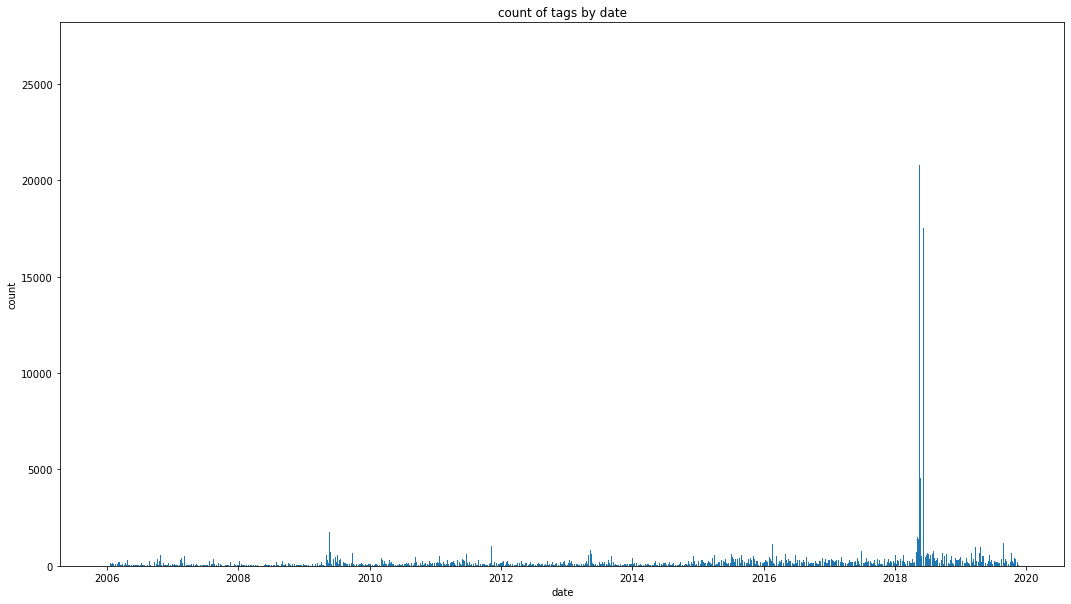

In [41]:
plt.figure(figsize=(18,10))
plt.bar(tagging_activity_x,tagging_activity_y)
plt.title('count of tags by date')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

Seems like the activity peaked extraordinarily around May/June 2018

### Daily active users during the tagging activity.

* Plot number of users who tagged at least one movie during the tagging activity date range

In [42]:
distinct_users_doing_tagging_by_date = tags.select('userId', 'tagging date') \
    .distinct() \
    .groupBy('tagging date') \
    .count()
# 
distinct_users_doing_tagging_by_date.orderBy(col('count').desc()).show(5)

+------------+-----+
|tagging date|count|
+------------+-----+
|  2015-08-17|  180|
|  2018-05-06|   87|
|  2018-05-05|   78|
|  2018-05-07|   71|
|  2015-07-27|   64|
+------------+-----+
only showing top 5 rows



In [43]:
# like before, we need to determine X and Y lists.

distinct_users_doing_tagging_by_date_x = distinct_users_doing_tagging_by_date \
                                        .select(col('tagging date')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()

distinct_users_doing_tagging_by_date_y = distinct_users_doing_tagging_by_date \
                                        .select(col('count')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()

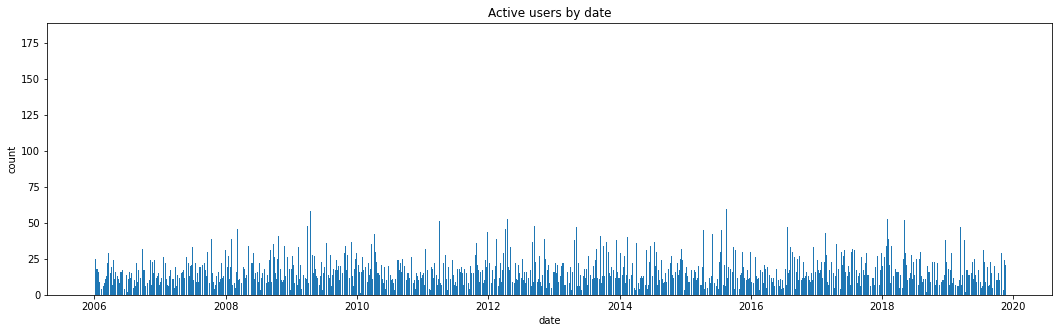

In [44]:
plt.figure(figsize=(18,5))
plt.bar(distinct_users_doing_tagging_by_date_x,distinct_users_doing_tagging_by_date_y)
plt.title('Active users by date')
plt.xlabel('date')
plt.ylabel('count')
plt.show()

Seems like while there were peaks and troughs, but visually, we don't see too much variation in the daily active users

## Insights from Problem Set 1

What have we learned from working on Problem Set 1?

1. Try to get a specific schema
1. Clean up data before analysis or aggregation
1. Clearly document weather you need case sensitive or case insensitive comparisions
1. Use ```df.withColumn``` to create new columns
1. ```col().contains()``` is like the ```LIKE``` clause in SQL, partial matches etc.
1. Spark Columns: Only use literal name where it's trivial, otherwise prefer ```col('name')```
1. ```distinct()``` vs ```groupBy()```
1. To convert a column in a spark data frame to a list (for plotting data or other uses) you isolate the column, convert to rdd, flatmap, collect.

# Problem Set 2  - ```movies.csv```

1. How many unique movies exist in the ```movies.csv``` dataset?  

1. Prepare a yearwise list of movies - Extract the year of release in movies.csv into a new column year_of_release   

1. List all unique genres found in ```movies.csv```, ordered lexically, case insensitive  

1. Prepare a genere wise list of movies - list all the movies for 'Crime', for 'Romance', and so on...  

1. Find number of films associated with each genre - add a new column to the movies dataframe: ```absolute_frequency_of_genre```  

1. Add another column ```num_genres``` and list total number of genres associated with each film  

1. Find out if a movie has both genres associated with it and also has ```(no genres listed)``` - if this is the case, find out how many such movies exist in the data set

1. Combinations of generes: Think about combinations of 2 genres...    
    * What is the frequency of each pair of genres? That is how many films belong to each unique pair of genres? 
        * For e.g. how many times do adventure and romance occur together? etc.
    * Are there generes that never occur together? 
    * Are there generes that always occur together? 
        * For e.g. in a multi-genre movie, whenever ```Comedy``` occurs is it always accompanied by ```Adventure```?

1. *[optional]* Is there a way to create a 2D matrix of genres - which clearly displays the absolute frequency of any pair of genres? *(hint: try pivot tables)*  

  

*[think]*: Is there a 'variety' metric? sum of absolute frequencies divided by total absolute frequency?  



## Solutions to Problem Set 2

### How many unique movies exist in the movies.csv dataset?

In [45]:
# this is what the movies_raw data looks like:
movies_raw.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Let's think about uniqueness 
* Do we look at ```movieId``` for uniqueness or ```title```?
* ```movieId``` sound like the right choice, as it'll keep the data consistent with tags, tag-relevance and ratings etc.
* *What could break here?* Let's try to articulate our assumptions and test them
* Can we assume that *primary keys mean unique movies*?
* Let's test that assumption, if it breaks, we'll know that our solutions must account for multiple ```movieId``` pointing to the same ```title```
* Following from above, can we assume that if the value in ```title``` matches for multiple ```movieId``` values then it's the same movie?
* Again, let's test this by building and reviewing the IMDB links

In [46]:
movies_with_matching_titles = movies_raw.groupby(col('title')).count().filter(col('count') > 1)
movies_with_matching_titles.orderBy(col('count').desc()).show(12)
movies_with_matching_titles.count()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|     Casanova (2005)|    2|
|Another World (2014)|    2|
|     Believer (2018)|    2|
|         Eros (2004)|    2|
|Let There Be Ligh...|    2|
|    Slow Burn (2000)|    2|
|   Absolution (2015)|    2|
|     Paradise (2013)|    2|
|  The Promise (2016)|    2|
|        Reset (2017)|    2|
|The Midnight Man ...|    2|
|         Eden (2014)|    2|
+--------------------+-----+
only showing top 12 rows



98

In [47]:
movies_raw.filter(col('title') == 'Casanova (2005)').show()

+-------+---------------+--------------------+
|movieId|          title|              genres|
+-------+---------------+--------------------+
|  42015|Casanova (2005)|Action|Adventure|...|
| 128862|Casanova (2005)|Comedy|Drama|Romance|
+-------+---------------+--------------------+



In [48]:
# links look different
links_raw.filter(col('movieId') == '42015').show()
links_raw.filter(col('movieId') == '128862').show()

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|  42015|0402894|  9681|
+-------+-------+------+

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
| 128862|0427042|122023|
+-------+-------+------+



In [49]:
# Right join to work out movieIds for all the movies with matching titles
movies_with_multiple_title_matches = movies_raw.join(movies_with_matching_titles, 'title', 'right')

In [50]:
# compare the imdbId values for all movies with matching 'title' values in movies_raw
links_for_movies_with_multiple_title_matches = \
    movies_with_multiple_title_matches.join(links_raw, 'movieId', 'left')

In [51]:
links_for_movies_with_multiple_title_matches.show(10)

+-------+--------------------+--------------------+-----+-------+------+
|movieId|               title|              genres|count| imdbId|tmdbId|
+-------+--------------------+--------------------+-----+-------+------+
| 128862|     Casanova (2005)|Comedy|Drama|Romance|    2|0427042|122023|
|  42015|     Casanova (2005)|Action|Adventure|...|    2|0402894|  9681|
| 156686|Another World (2014)|  (no genres listed)|    2|3500888|355925|
| 140633|Another World (2014)|         Documentary|    2|3326110|262897|
| 198947|     Believer (2018)|        Action|Crime|    2|7095654|518963|
| 190199|     Believer (2018)|         Documentary|    2|7689424|490001|
| 147002|         Eros (2004)|       Drama|Romance|    2|0343663| 39850|
|  32600|         Eros (2004)|               Drama|    2|0377059|  null|
| 191867|Let There Be Ligh...|         Documentary|    2|6184774|438442|
| 179783|Let There Be Ligh...|  (no genres listed)|    2|5804314|480881|
+-------+--------------------+--------------------+

In [52]:
# counts are all 1 - therefore all movies with matching titles still are unique movies
links_for_movies_with_multiple_title_matches.groupBy(col('imdbId')).count().orderBy(col('count').desc()).show(5)

# conclusion: all movies in movies.csv are unique.

+--------+-----+
|  imdbId|count|
+--------+-----+
| 6306400|    1|
| 2463842|    1|
|10376068|    1|
| 0449040|    1|
| 0377059|    1|
+--------+-----+
only showing top 5 rows



In [53]:
# number of unique movies in movies.csv
movies_raw.distinct().count()

62423

The [site](https://grouplens.org/datasets/movielens/25m/) also reads:  

"MovieLens 25M movie ratings. Stable benchmark dataset. 25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users. Includes tag genome data with 15 million relevance scores across 1,129 tags. Released 12/2019"

So we seem to be in the right ballpark here.  
Let's continue with our analysis.

### Extract the year of release in movies.csv into a new column year_of_release

In [54]:
# let's build a regex pattern to isolate the year of release
# this should be the last set of parenthesis in the title
# the regex needs a backslash to escape the parenthesis symbols, as these are used to identify groups
open_paren = '\\('
close_paren = '\\)'
# this should have only 4 digits between the parenthesis
year_pattern = '([0-9]{4})'
# the title should end with the closing parenthesis
close_paren = close_paren+'$'
# ignore whitespace
# keep unicode in mind
# global
# options_pattern = '/gxu'
# final pattern: the options_pattern thing is not supported in python  
year_of_release_regex = open_paren+year_pattern+close_paren#+options_pattern
print(year_of_release_regex)

\(([0-9]{4})\)$


In [55]:
from pyspark.sql.functions import regexp_extract

In [56]:
# our regex has 2 groups, 
# 0 gives the first group match i.e. (1995)
# 1 gives the next group match i.e. 1995
movies_raw.withColumn(
    'year_of_release_0', regexp_extract(col('title'), year_of_release_regex, 0)).withColumn(
    'year_of_release_1', regexp_extract(col('title'), year_of_release_regex, 1)).show(10)

+-------+--------------------+--------------------+-----------------+-----------------+
|movieId|               title|              genres|year_of_release_0|year_of_release_1|
+-------+--------------------+--------------------+-----------------+-----------------+
|      1|    Toy Story (1995)|Adventure|Animati...|           (1995)|             1995|
|      2|      Jumanji (1995)|Adventure|Childre...|           (1995)|             1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|           (1995)|             1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           (1995)|             1995|
|      5|Father of the Bri...|              Comedy|           (1995)|             1995|
|      6|         Heat (1995)|Action|Crime|Thri...|           (1995)|             1995|
|      7|      Sabrina (1995)|      Comedy|Romance|           (1995)|             1995|
|      8| Tom and Huck (1995)|  Adventure|Children|           (1995)|             1995|
|      9| Sudden Death (1995)|  

In [57]:
# so we'll use group 1 to create our dataframe
movies = movies_raw.withColumn(
    'year_of_release', regexp_extract(col('title'), year_of_release_regex, 1))

In [58]:
movies.show(10)

+-------+--------------------+--------------------+---------------+
|movieId|               title|              genres|year_of_release|
+-------+--------------------+--------------------+---------------+
|      1|    Toy Story (1995)|Adventure|Animati...|           1995|
|      2|      Jumanji (1995)|Adventure|Childre...|           1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|
|      5|Father of the Bri...|              Comedy|           1995|
|      6|         Heat (1995)|Action|Crime|Thri...|           1995|
|      7|      Sabrina (1995)|      Comedy|Romance|           1995|
|      8| Tom and Huck (1995)|  Adventure|Children|           1995|
|      9| Sudden Death (1995)|              Action|           1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|           1995|
+-------+--------------------+--------------------+---------------+
only showing top 10 rows



### List all unique genres found in movies.csv, ordered lexically, case insensitive

In [59]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

In [60]:
# unique genres found in movies.csv
movie_genres = movies_raw.select(
    explode( # convert each element in an array to a new row
        split( # split the data on pipe and create an arry
            movies_raw.genres, "\|"
        )
    ).alias('genre')
)

In [61]:
unique_movie_genres = movie_genres.distinct()
unique_movie_genres.show()

+------------------+
|             genre|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



### Find number of films associated with each genre - absolute_frequency_of_genre  

In [62]:
movie_genres_with_abs_freq = movie_genres.groupBy('genre').count()
movie_genres_with_abs_freq = movie_genres_with_abs_freq.orderBy(col('count').desc()) \
                            .withColumnRenamed('count', 'absolute_frequency_of_genre')

movie_genres_with_abs_freq.show()
# TODO: rename the column 'count' to 'freq'

+------------------+---------------------------+
|             genre|absolute_frequency_of_genre|
+------------------+---------------------------+
|             Drama|                      25606|
|            Comedy|                      16870|
|          Thriller|                       8654|
|           Romance|                       7719|
|            Action|                       7348|
|            Horror|                       5989|
|       Documentary|                       5605|
|             Crime|                       5319|
|(no genres listed)|                       5062|
|         Adventure|                       4145|
|            Sci-Fi|                       3595|
|          Children|                       2935|
|         Animation|                       2929|
|           Mystery|                       2925|
|           Fantasy|                       2731|
|               War|                       1874|
|           Western|                       1399|
|           Musical|

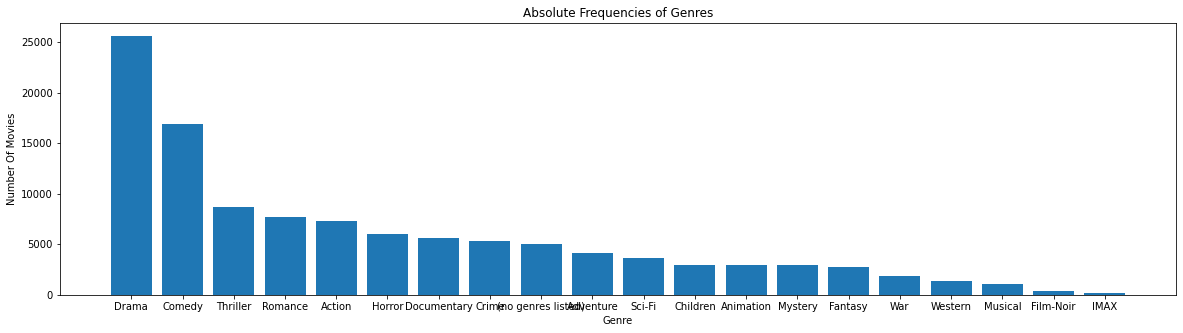

In [63]:
# convert each column to a list
movie_genres_with_abs_freq_x = movie_genres_with_abs_freq \
                                        .select(col('genre')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()
movie_genres_with_abs_freq_y = movie_genres_with_abs_freq \
                                        .select(col('absolute_frequency_of_genre')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()

plt.figure(figsize=(20,5))
plt.bar(movie_genres_with_abs_freq_x,movie_genres_with_abs_freq_y)
plt.title('Absolute Frequencies of Genres')
plt.xlabel('Genre')
plt.ylabel('Number Of Movies')
plt.show()

### List total number of genres associated with each film

* Add another column num_genres and list total number of genres associated with each film

In [64]:
# like before we'll split the genres column on | and count the elements
# 
from pyspark.sql.functions import size

movies = movies.withColumn('num_genres',
                           size(split(col('genres'), '\|')))

In [65]:
movies.show(10, False)

+-------+----------------------------------+-------------------------------------------+---------------+----------+
|movieId|title                             |genres                                     |year_of_release|num_genres|
+-------+----------------------------------+-------------------------------------------+---------------+----------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995           |5         |
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995           |3         |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995           |2         |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995           |3         |
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995           |1         |
|6      |Heat (1995)                       |Action|Crime|Thriller       

### Prepare a genere wise list of movies

* list all the movies for 'Crime', for 'Romance', and so on...

A naive appoach would be to filter movies for each genre that we know. This is doable as the number of genres we found is small. But it's not flexible and will need revision as new genres come to light. In practice, we may need something that's more dynamic.

In [66]:
romance = movies.where(col('genres').like('%Romance%'))
romance.show()

+-------+--------------------+--------------------+---------------+----------+
|movieId|               title|              genres|year_of_release|num_genres|
+-------+--------------------+--------------------+---------------+----------+
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|         2|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|         3|
|      7|      Sabrina (1995)|      Comedy|Romance|           1995|         2|
|     11|American Presiden...|Comedy|Drama|Romance|           1995|         3|
|     15|Cutthroat Island ...|Action|Adventure|...|           1995|         3|
|     17|Sense and Sensibi...|       Drama|Romance|           1995|         2|
|     25|Leaving Las Vegas...|       Drama|Romance|           1995|         2|
|     28|   Persuasion (1995)|       Drama|Romance|           1995|         2|
|     33|Wings of Courage ...|Adventure|Romance...|           1995|         3|
|     35|   Carrington (1995)|       Drama|Romance| 

In [67]:
westerns = movies.where(col('genres').like('%Western%'))
westerns.show()

+-------+--------------------+--------------------+---------------+----------+
|movieId|               title|              genres|year_of_release|num_genres|
+-------+--------------------+--------------------+---------------+----------+
|    163|    Desperado (1995)|Action|Romance|We...|           1995|         3|
|    210|    Wild Bill (1995)|             Western|           1995|         1|
|    266|Legends of the Fa...|Drama|Romance|War...|           1994|         4|
|    303|Quick and the Dea...|Action|Thriller|W...|           1995|         3|
|    368|     Maverick (1994)|Adventure|Comedy|...|           1994|         3|
|    383|   Wyatt Earp (1994)|             Western|           1994|         1|
|    416|    Bad Girls (1994)|             Western|           1994|         1|
|    432|City Slickers II:...|Adventure|Comedy|...|           1994|         3|
|    458|Geronimo: An Amer...|       Drama|Western|           1993|         2|
|    487|Lightning Jack (1...|      Comedy|Western| 

In [68]:
no_genres_listed = movies.where(col('genres').like('%(no genres listed)%'))
no_genres_listed.show()
no_genres_listed.count()

+-------+--------------------+------------------+---------------+----------+
|movieId|               title|            genres|year_of_release|num_genres|
+-------+--------------------+------------------+---------------+----------+
|  83773|Away with Words (...|(no genres listed)|           1999|         1|
|  84768|   Glitterbug (1994)|(no genres listed)|           1994|         1|
|  86493|Age of the Earth,...|(no genres listed)|           1980|         1|
|  87061|Trails (Veredas) ...|(no genres listed)|           1978|         1|
|  91246|Milky Way (Tejút)...|(no genres listed)|           2007|         1|
|  92435|Dancing Hawk, The...|(no genres listed)|           1978|         1|
|  92641|Warsaw Bridge (Po...|(no genres listed)|           1990|         1|
|  94431|Ella Lola, a la T...|(no genres listed)|           1898|         1|
|  95750|Promise of the Fl...|(no genres listed)|           1975|         1|
|  96479|  Nocturno 29 (1968)|(no genres listed)|           1968|         1|

5062

Yeah...this is not a good approach.  

We want to be able to address as many generes as found in data, even though the list is available, it makes more sense to generate a list for all distinct values in the data

Can we create a column where there's only one 'genre' and the movie is duplicated as many times as the genre?

Spark Joins to the rescue.  

We'll create a ```full outer``` join (aka 'full' or 'outer') - resulting in each row in movies to be repeated once for each genere associated with it. If "127 Hours" has 3 genres "Adventure|Drama|Thriller" then it will now be in 3 rows, one each for "adventure", "drama" and "thriller".

In [69]:
movies_expanded_by_genre = movies.join(unique_movie_genres, col('genres').contains(col('genre')) , 'fullouter')
# movie_genres_with_abs_freq
movies_expanded_by_genre.orderBy(col('title')).show(25, True)

+-------+--------------------+--------------------+---------------+----------+-----------+
|movieId|               title|              genres|year_of_release|num_genres|      genre|
+-------+--------------------+--------------------+---------------+----------+-----------+
| 208297|"BLOW THE NIGHT!"...|   Documentary|Drama|           1983|         2|Documentary|
| 208297|"BLOW THE NIGHT!"...|   Documentary|Drama|           1983|         2|      Drama|
|  51372|"Great Performanc...|             Musical|           1998|         1|    Musical|
| 136604|#1 Cheerleader Ca...|        Comedy|Drama|           2010|         2|      Drama|
| 136604|#1 Cheerleader Ca...|        Comedy|Drama|           2010|         2|     Comedy|
| 183901|    #Captured (2017)|              Horror|           2017|         1|     Horror|
| 195955|#Female Pleasure ...|         Documentary|           2018|         1|Documentary|
| 203417|    #FollowMe (2019)|     Horror|Thriller|           2019|         2|   Thriller|

Now we can simply filter by genre from the same dataframe.

In [70]:
romance1 = movies_expanded_by_genre.filter(col('genre') == 'Romance')
romance1.show()

+-------+--------------------+--------------------+---------------+----------+-------+
|movieId|               title|              genres|year_of_release|num_genres|  genre|
+-------+--------------------+--------------------+---------------+----------+-------+
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|         2|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|         3|Romance|
|      7|      Sabrina (1995)|      Comedy|Romance|           1995|         2|Romance|
|     11|American Presiden...|Comedy|Drama|Romance|           1995|         3|Romance|
|     15|Cutthroat Island ...|Action|Adventure|...|           1995|         3|Romance|
|     17|Sense and Sensibi...|       Drama|Romance|           1995|         2|Romance|
|     25|Leaving Las Vegas...|       Drama|Romance|           1995|         2|Romance|
|     28|   Persuasion (1995)|       Drama|Romance|           1995|         2|Romance|
|     33|Wings of Courage ...|Adventure|Rom

So ```movies_expanded_by_genre``` is it.

### Find out if a movie has both genres associated with it and also has ```(no genres listed)```  

* if this is the case, find out how many such movies exist in the data set

In [71]:
# filter out the movies with (no genres listed)
# where and filter, like and contains - use what is most readable
# also remove the %xxx% for contains...

# 1
# movies.where(col('genres').contains('no genres')).show()

# 2
# movies.where(col('genres').like('%no genres%')).show()

# 3
# movies.filter(col('genres').like('%no genres%')).show()

# 4
movies.filter(col('genres').contains('no genres')).show(10)

+-------+--------------------+------------------+---------------+----------+
|movieId|               title|            genres|year_of_release|num_genres|
+-------+--------------------+------------------+---------------+----------+
|  83773|Away with Words (...|(no genres listed)|           1999|         1|
|  84768|   Glitterbug (1994)|(no genres listed)|           1994|         1|
|  86493|Age of the Earth,...|(no genres listed)|           1980|         1|
|  87061|Trails (Veredas) ...|(no genres listed)|           1978|         1|
|  91246|Milky Way (Tejút)...|(no genres listed)|           2007|         1|
|  92435|Dancing Hawk, The...|(no genres listed)|           1978|         1|
|  92641|Warsaw Bridge (Po...|(no genres listed)|           1990|         1|
|  94431|Ella Lola, a la T...|(no genres listed)|           1898|         1|
|  95750|Promise of the Fl...|(no genres listed)|           1975|         1|
|  96479|  Nocturno 29 (1968)|(no genres listed)|           1968|         1|

In [72]:
# number of records where num_genres is more than 1 for (no genres listed)
movies.filter(col('genres') \
            .contains('no genres')) \
            .filter(col('num_genres')>1) \
            .count()

0

In [73]:
# alternatively list num_genres in descending order
movies.filter(col('genres') \
            .contains('no genres')) \
            .orderBy(col('num_genres').desc()) \
            .show(10)

+-------+--------------------+------------------+---------------+----------+
|movieId|               title|            genres|year_of_release|num_genres|
+-------+--------------------+------------------+---------------+----------+
|  83773|Away with Words (...|(no genres listed)|           1999|         1|
|  84768|   Glitterbug (1994)|(no genres listed)|           1994|         1|
|  86493|Age of the Earth,...|(no genres listed)|           1980|         1|
|  87061|Trails (Veredas) ...|(no genres listed)|           1978|         1|
|  91246|Milky Way (Tejút)...|(no genres listed)|           2007|         1|
|  92435|Dancing Hawk, The...|(no genres listed)|           1978|         1|
|  92641|Warsaw Bridge (Po...|(no genres listed)|           1990|         1|
|  94431|Ella Lola, a la T...|(no genres listed)|           1898|         1|
|  95750|Promise of the Fl...|(no genres listed)|           1975|         1|
|  96479|  Nocturno 29 (1968)|(no genres listed)|           1968|         1|

So there's no movies where ```(no genres listed)``` is mixed with other genres.

### Combinations of generes: Think about combinations of 2 genres...  

* What is the frequency of each genre pair of occuring together? 
    * For e.g. how many times do adventure and romance occur together? etc.
* Are there generes that never occur together? 
* Are there generes that always occur together? 
    * For e.g. in a multi-genre movie, whenever ```Comedy``` occurs is it always accompanied by ```Adventure```?

#### Find all pairs of genres

We'll need to generate a new dataframe which has all **bi**grams (pair of 2 genres occuring together) of genres.

see: [n-grams](https://en.wikipedia.org/wiki/N-gram) aka Q-grams  
Another [note on n-grams](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

#####  **Approach 1**  
  
A seemingly obvious method would be to use ```df.crossJoin``` *(and ```df.withColumnRenamed``` to avoid confusing column names)*...  
Let's try that first and see...  

In [74]:
# first create two columns, resulting in all combinations 
# filter out duplicates (no duplicates - no records with same value in col1 and col2)
# this filters out movies with only one genre defined
movie_genre_bigrams_1 = unique_movie_genres.select(col('genre')) \
    .withColumnRenamed('genre', 'genre1') \
    .crossJoin(unique_movie_genres.select(col('genre')).withColumnRenamed('genre', 'genre2')) \
    .filter(col('genre1') != col('genre2'))

In [75]:
# create another column where genre values are concatenated - just so we are able to see the values clearly
from pyspark.sql.functions import concat_ws

movie_genre_bigrams_1 = movie_genre_bigrams_1.withColumn('2_genre_combos', concat_ws('|', col('genre1'), col('genre2')))

In [76]:
movie_genre_bigrams_1.show()

+-------+------------------+--------------------+
| genre1|            genre2|      2_genre_combos|
+-------+------------------+--------------------+
|  Crime|           Romance|       Crime|Romance|
|  Crime|          Thriller|      Crime|Thriller|
|  Crime|         Adventure|     Crime|Adventure|
|  Crime|             Drama|         Crime|Drama|
|  Crime|               War|           Crime|War|
|  Crime|       Documentary|   Crime|Documentary|
|  Crime|           Fantasy|       Crime|Fantasy|
|  Crime|           Mystery|       Crime|Mystery|
|  Crime|           Musical|       Crime|Musical|
|  Crime|         Animation|     Crime|Animation|
|  Crime|         Film-Noir|     Crime|Film-Noir|
|  Crime|(no genres listed)|Crime|(no genres ...|
|  Crime|              IMAX|          Crime|IMAX|
|  Crime|            Horror|        Crime|Horror|
|  Crime|           Western|       Crime|Western|
|  Crime|            Comedy|        Crime|Comedy|
|  Crime|          Children|      Crime|Children|


*OBSERVATION*: A problem with the dataset above is that for the context of our data, ```Crime|Romance``` is the same as ```Romance|Crime```, we need to find an efficient way that our analysis is independent of the order of genres in the concatenated string.  

We need to look for *combinations* not *permutations* as the order of genres is not significant for our purposes.

I have a suspicion that this cross-join based approach may not work for solving the actual question - that how many unique movies exist for every combination of genre... let's try solving it and find out.

##### What is the frequency of each pair of genres? - **Approach 1**

aka How many films belong to each unique pair of genres?  
* For e.g. how many times do adventure and romance occur together? etc.  
  
Wokay... keeping the *observation* in mind, let's see how we'd solve for a list of movies

In [77]:
# all the movies in expanded genre where the genre matches genre1 in co

compound_condition = [(movies_expanded_by_genre['genre'] == movie_genre_bigrams_1['genre1']),
                     (movies_expanded_by_genre['genres'].contains(movie_genre_bigrams_1['genre2']))]
movies_with_bigrams_1 = movies_expanded_by_genre.join(movie_genre_bigrams_1, 
                               compound_condition,
                              'inner') \
                        .orderBy(col('title').asc())

In [78]:
movies_with_bigrams_1.show(15, False)

+-------+-------------------------------------------------------+-----------------------------+---------------+----------+-----------+-----------+-----------+-----------------+
|movieId|title                                                  |genres                       |year_of_release|num_genres|genre      |genre1     |genre2     |2_genre_combos   |
+-------+-------------------------------------------------------+-----------------------------+---------------+----------+-----------+-----------+-----------+-----------------+
|208297 |"BLOW THE NIGHT!" Let's Spend the Night Together (1983)|Documentary|Drama            |1983           |2         |Drama      |Drama      |Documentary|Drama|Documentary|
|208297 |"BLOW THE NIGHT!" Let's Spend the Night Together (1983)|Documentary|Drama            |1983           |2         |Documentary|Documentary|Drama      |Documentary|Drama|
|136604 |#1 Cheerleader Camp (2010)                             |Comedy|Drama                 |2010           |2   

Yeah...  
As expected, we get twice the number of results. One for ```Thriller|Horror``` and another for ```Horror|Thriller```  


In [79]:
# just for fun
movie_bigram_1_freq = movies_with_bigrams_1.groupBy('genre1', 'genre2').count()

In [80]:
# compare counts of two sets to see if they match
movie_bigram_1_freq.filter(col('genre1')=='Comedy').orderBy(col('count').desc()).show(25)
movie_bigram_1_freq.filter(col('genre1')=='Romance').orderBy(col('count').desc()).show(25)

+------+-----------+-----+
|genre1|     genre2|count|
+------+-----------+-----+
|Comedy|      Drama| 4603|
|Comedy|    Romance| 3450|
|Comedy|     Action| 1333|
|Comedy|   Children| 1169|
|Comedy|      Crime| 1044|
|Comedy|  Adventure| 1004|
|Comedy|  Animation|  855|
|Comedy|    Fantasy|  836|
|Comedy|     Horror|  790|
|Comedy|   Thriller|  647|
|Comedy|     Sci-Fi|  577|
|Comedy|    Musical|  519|
|Comedy|    Mystery|  364|
|Comedy|    Western|  215|
|Comedy|Documentary|  200|
|Comedy|        War|  180|
|Comedy|       IMAX|   29|
|Comedy|  Film-Noir|    9|
+------+-----------+-----+

+-------+-----------+-----+
| genre1|     genre2|count|
+-------+-----------+-----+
|Romance|      Drama| 4654|
|Romance|     Comedy| 3450|
|Romance|     Action|  543|
|Romance|   Thriller|  488|
|Romance|  Adventure|  436|
|Romance|      Crime|  397|
|Romance|    Fantasy|  390|
|Romance|    Musical|  352|
|Romance|        War|  275|
|Romance|    Mystery|  259|
|Romance|   Children|  208|
|Romance|    

The counts seem to match but in some cases there's odd numbers here... like ```Romance|Action``` has 543 movies - how does that work?

In [81]:
movies_with_bigrams_1.filter(col('genre1')=='Comedy').filter(col('genre2') == 'Western').select(col('title')).show(50,False)

+-----------------------------------------------------------------------------------------------------------+
|title                                                                                                      |
+-----------------------------------------------------------------------------------------------------------+
|'49-'17 (1917)                                                                                             |
|4 for Texas (1963)                                                                                         |
|800 Bullets (800 Balas) (2002)                                                                             |
|A Man from Boulevard des Capucines (1987)                                                                  |
|A Million Ways to Die in the West (2014)                                                                   |
|A Talent for Loving (1969)                                                                                 |
|A Ticket 

##### Approach 2

Using the n-gram function 

## Insights from Problem Set 2

What have we learned from working on Problem Set 2?

1. Regex based matching, pay attention to the regex group you want to extract
1. Explode (convert array in the column value into rows) and Split (convert string into array based on a token)
1. size() is the pySpark equivalent of len(array)
	* There's like 4 of these that you should [familiarize yourself](https://sparkbyexamples.com/pyspark/pyspark-explode-array-and-map-columns-to-rows/) with: ```explode()```, ```explore_outer()```, ```posexplode()```, ```posexplode_outer()```
1. That DataFrame>Select>RDD>FlatMap>Collect thing for creating lists out of dataframe columns for plotting etc. - it's just tedious, so try to remember it
1. [joi](https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/).[ns](https://github.com/spark-examples/pyspark-examples/blob/master/pyspark-join-two-dataframes.py), [joins](https://www.geeksforgeeks.org/pyspark-join-types-join-two-dataframes/), [joins](https://dzone.com/articles/pyspark-join-explained-with-examples), [can't get](https://medium.com/@achilleus/https-medium-com-joins-in-apache-spark-part-1-ce289bfc84c9) [enough](https://medium.com/@achilleus/https-medium-com-joins-in-apache-spark-part-2-5b038bc7455b) of 'em. 
1. Also, ```crossJoin``` when you need a cartesian product (cross product) and have no conditions. 
    * Spark >= 3.0. ```spark.sql.crossJoin.enable``` is ```True``` by default, if not, you'll need to ```SparkSession.config("spark.sql.crossJoin.enable",True)```
1. ```where``` and ```filter```, ```like``` and ```contains```

# Problem Set 3  - ```ratings.csv```

1. Find number of films for each rating, so number of films that have at least one rating of 1, number of films that have at least one rating of 2 and so on...  

1. List user-IDs in order of number of films they have rated, descending.  

1. Are there users who have given multiple ratings to the same film?  

## Solutions to Problem Set 3

### Find number of films for each rating

* so number of films that have at least one rating of 1, number of films that have at least one rating of 2 and so on...

In [82]:
# to refresh, here's what ratings data looks like
ratings_raw.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
+------+-------+------+----------+
only showing top 10 rows



In [83]:
absolute_freq_ratings = ratings_raw.groupBy('rating').count()

In [84]:
absolute_freq_ratings.orderBy(col('count').desc()).show()

+------+-------+
|rating|  count|
+------+-------+
|   4.0|6639798|
|   3.0|4896928|
|   5.0|3612474|
|   3.5|3177318|
|   4.5|2200539|
|   2.0|1640868|
|   2.5|1262797|
|   1.0| 776815|
|   1.5| 399490|
|   0.5| 393068|
+------+-------+



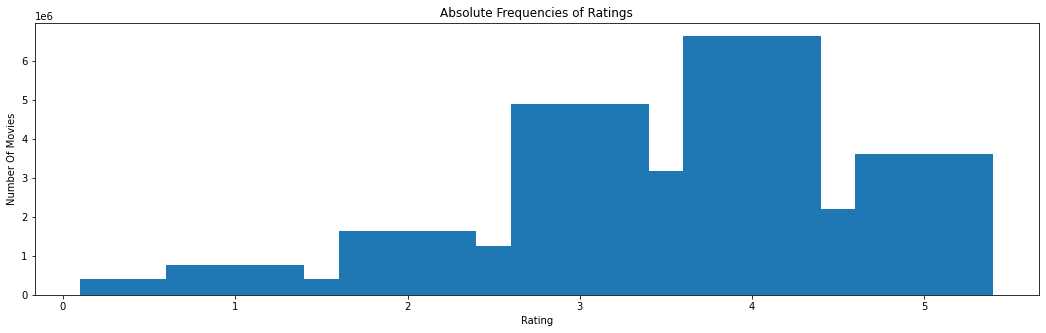

In [85]:
# convert each column to a list
absolute_freq_ratings_x = absolute_freq_ratings \
                                        .select(col('rating')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()
absolute_freq_ratings_y = absolute_freq_ratings \
                                        .select(col('count')) \
                                        .rdd \
                                        .flatMap(lambda x: x) \
                                        .collect()

plt.figure(figsize=(18,5))
plt.bar(absolute_freq_ratings_x,absolute_freq_ratings_y)
plt.title('Absolute Frequencies of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number Of Movies')
plt.show()

### List user-IDs in order of number of films they have rated, descending

In [86]:
rating_freq_by_user = ratings_raw.groupBy('userId').count()

In [87]:
rating_freq_by_user.orderBy(col('count').desc()).show()

+------+-----+
|userId|count|
+------+-----+
| 72315|32202|
| 80974| 9178|
|137293| 8913|
| 33844| 7919|
| 20055| 7488|
|109731| 6647|
| 92046| 6564|
| 49403| 6553|
| 30879| 5693|
|115102| 5649|
|110971| 5633|
| 75309| 5525|
| 78849| 5276|
| 61010| 5244|
| 29803| 5219|
|122011| 5160|
| 57548| 5066|
| 93855| 5045|
|103611| 4861|
| 34987| 4831|
+------+-----+
only showing top 20 rows



In [88]:
rating_freq_by_user.count()

162541

That's a lot of ratings by a lot of users...  

Some of these like ```72315``` def seem like a bot - or a human whose spent a lot of time regularly watching films - if we estimate a film to be 90 minutes on an average, it comes to about 48303 hours - that's like 5.5 years of 24/7 movie-watching! In practice this would've taken the person 8-10 times longer (considering 3 hours of movies daily - no holidays) - so 44 to 55 years of movies... - yeah, I'll bet this was some automated thing



### Are there users who have given multiple ratings to the same film?

In [89]:
usr_movie_count = ratings_raw.groupBy('userId', 'movieId').count()

In [92]:
usr_movie_count.orderBy(col('count').asc()).show(10)

+------+-------+-----+
|userId|movieId|count|
+------+-------+-----+
|     1|   1237|    1|
|     1|   2161|    1|
|     1|   2573|    1|
|     1|  27266|    1|
|     1|  32591|    1|
|     1|   4325|    1|
|     1|   5878|    1|
|     1|   7318|    1|
|     1|   7820|    1|
|     1|   7939|    1|
+------+-------+-----+
only showing top 10 rows



Doesn't seem like users have rated the same movie multiple times.
*[think]* is there another way to confirm this?

## Insights from Problem Set 3

We are practicing some of the same stuff, however ```ratings``` is a substantially larger dataset - we need to be more careful with joins etc.

# Problem Set 4  - mixing things up, ```movies + ratings```

1. Which genres have recieved the highest number of ratings?

1. What are the 20 highest rated movies in each genre?
    * *[think]* one way to find our 'highest rated' would be by summing all the occurances of 4 and 5 stars for each movie in each genre and sorting from highest to lowest

1. Prepare an ```avg_rating``` column for the movies dataframe where you add the average rating that movie has recieved rounded to 2 places of decimal
    * If the movie has recieved no rating, add 0

1. Prepare a ```rating_freq``` column for the movies dataframe where you add the number of times the movie recieved a rating
    * If the movie did not recieve any rating, put in 0
    
1. Prepare a ```rating_freq_user``` column for the movied dataframe where you add the number of unique users who rated the film
    * If no one rated the film, put in 0
    
1. How many films where the ```rating_freq``` differs from ```rating_freq_user```? Does this match the analysis we did for ```ratings.csv```?

1. Prepare a list of highly rated movies, present this list by year of release and sorted in alphabetical order by movie title.  
    * "Highly Rated" = movies with atleast 3 instances where users have rated the film a 4 or a 5
    * Expected Columns in the output: ```year of release, movie title, # of 4s, # of 5s```  
    
1. Another approach to 'highly rated', prepare a list of 'highly rated' movies
    * "Highly Rated" = sum of 4 and 5 ratings is the highest across all years
    * Sort this list by year of release

1. *[think]* Can we find "Late Bloomers" or "Cult Films"? 
    * Films that were not highly rated during the year of release or were not well rated initially,but their ratings improve over time. 
    * How can we rank these in descending order of "Cult Status"?


## Solutions to Problem Set 4

### Which genres have recieved the highest number of ratings?

### What are the 20 highest rated movies in each genre?

### Prepare an ```avg_rating``` column for the movies dataframe where you add the average rating that movie has recieved rounded to 2 places of decimal

### Prepare a ```rating_freq``` column for the movies dataframe where you add the number of times the movie recieved a rating

### Prepare a ```rating_freq_user``` column for the movied dataframe where you add the number of unique users who rated the film

# Problem Set 5 - Including the Tag Genome

1. Cross-check tags from the tag genome, insert tag_genome_id and relevance score, save file as tags_with_relevance.csv  
    * columns: ```movieId, tagId, tag, relevance```
    * this data structure would be massive as tag values would get repeated
    * [todo]: let's reconsider this question


# Problem Set 6 - Writing your Outputs

1. Persist the new movies dataframe with the added ```avg_rating, rating_freq, rating_freq_user``` columns.

# Problem Set 7  - Bonus!


1. Just fun on string operations: Prepare a list of movies that have atleast two vowels except 'e' - sort the list by month and year of video release.  
   * Expected Columns in the output: ```year of video release, month of video release, movie title, # of vowels that are not e```  